<a href="https://colab.research.google.com/github/ganeshbmc/markets/blob/master/quant%20trading/volatility/iv_vs_rv_nifty_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# !pip install breeze_connect
# !pip install yfinance
# !pip install pandas_ta

In [45]:
import pandas as pd
import numpy as np
import pandas_ta as ta
# import talib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math as m
import yfinance as yf
import breeze_connect
from breeze_connect import BreezeConnect

print("Imported necessary libraries")

Imported necessary libraries


## Start breeze_connect  

In [4]:
# Generate session token for each day  
# Log into this site while the 'developer tools -> network' tab is open (https://api.icicidirect.com/apiuser/login?api_key=06890j43os6a521A7b7241i934KQ9S56)   
# Copy 'API_session' key for 'payload' section in 127.0.0.1  

fresh_token = 7734262
# with open(r"D:\Github\markets\token_breeze.txt", "w") as f:
#     f.write(str(fresh_token))

In [47]:
isec = BreezeConnect(api_key="06890j43os6a521A7b7241i934KQ9S56")
isec.generate_session(
    api_secret="$42367K2z98758S712349896J6i^64Mx",
    session_token=fresh_token)

## Data for FY2022-2023

In [48]:
# start_date = dt.date(2022,4,1)
# end_date = dt.date(2023,4, 1)
# start_date, end_date

In [49]:
# Get data from yfinance

# Nifty daily

# df = yf.download(tickers="^NSEI", interval="1d", start=start_date, end=end_date)
# df.to_csv("nifty_daily_fy_22-23.csv")

# Indiavix daily - NOT working
# df = yf.download(tickers="^INDIAVIX", interval="1d", start=start_date, end=end_date)
# df.to_csv("indiavix_daily_fy_22-23.csv")

# Got Indiavix data from investing.com
# dfv = pd.read_html("file:///home/ganesh/Downloads/vix.html")[0]
# dfv.to_csv("indiavix_daily_fy_22-23.csv")

In [50]:
# Get nifty data stored in a local file
# nifty = pd.read_excel("/home/ganesh/Github/markets/quant trading/volatility/nifty_daily_fy_22_23.xlsx")
# nifty.tail()

In [51]:
# Get indiavix data stored in a local file
# vix = pd.read_excel("/home/ganesh/Github/markets/quant trading/volatility/indiavix_daily_fy_22_23.xlsx")
# vix["Date"] = pd.to_datetime(vix["Date"], format="%b %d, %Y")
# vix.sort_values(by="Date", inplace=True)
# vix = vix.iloc[1:, :]
# vix

In [52]:
# Get nifty data using breeze_connect

# nifty_dict = isec.get_historical_data(
#     interval="1day", 
#     from_date=start_date.strftime("%Y-%m-%d"), 
#     to_date=end_date.strftime("%Y-%m-%d"),
#     stock_code="NIFTY",
#     exchange_code="NSE",
#     product_type="",
#     expiry_date="")

# # nifty_dict 

# nifty = pd.DataFrame(nifty_dict['Success'])
# print(nifty.shape)
# print(nifty.columns)
# nifty.tail()

In [53]:
# Get indiavix data using breeze_connect

# vix_dict = isec.get_historical_data(
#     interval="1day", 
#     from_date=start_date.strftime("%Y-%m-%d"), 
#     to_date=end_date.strftime("%Y-%m-%d"),
#     stock_code="INDVIX",
#     exchange_code="NSE",
#     product_type="",
#     expiry_date="")

# # vix_dict 

# vix = pd.DataFrame(vix_dict['Success'])
# print(vix.shape)
# print(vix.columns)
# vix.tail()

### Function to get data in required format using breeze_connect  

In [54]:
def get_data_using_breeze(client, stock_code: str, interval: str, from_date: str, to_date: str) -> pd.DataFrame:
    data_dict = client.get_historical_data(interval=interval, 
                                        from_date=from_date, 
                                        to_date=to_date,
                                        stock_code=stock_code,
                                        exchange_code="NSE",
                                        product_type="",
                                        expiry_date="")
    df = pd.DataFrame(data_dict["Success"])
    df = df[['datetime', 'open', 'high', 'low', 'close', 'volume']]
    df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df

In [55]:
nifty = get_data_using_breeze(isec, "NIFTY", "1day", "2018-04-01", "2023-03-31")
vix = get_data_using_breeze(isec, "INDVIX", "1day", "2018-04-01", "2023-03-31")

nifty.shape, vix.shape

((1241, 6), (1241, 6))

### Function for IV based predictions  

In [56]:
def iv_based_predictions(spot_price, atm_iv, days_to_expiry=1, risk_stddev=1.25):
    exp_move_pct = (atm_iv/(np.sqrt(256/days_to_expiry)))
    exp_move_pct_for_desired_risk = exp_move_pct * risk_stddev
    # return exp_move_pct, exp_move_pct_for_desired_risk
    points_move = (spot_price * (exp_move_pct_for_desired_risk/100)).round(0)
    lower_strike = (spot_price - points_move).round(0)
    upper_strike = (spot_price + points_move).round(0)
    return exp_move_pct_for_desired_risk, points_move, lower_strike, upper_strike

In [57]:
def add_volatility_based_measures(underlying_ohlcv: pd.DataFrame, 
                                    volatility_ohlcv: pd.DataFrame,
                                    days_to_expiry: float,
                                    risk_stddev: float) -> pd.DataFrame:
    # Add realized volatility measures
    data = underlying_ohlcv.copy()
    data["points_move"] = data["close"].diff().round()
    data["abs_points_move"] = abs(data["points_move"])
    data["returns"] = data["close"].pct_change()

    # Add implied volatility measures
    data["indiavix"] = volatility_ohlcv["close"]
    data[["exp_move_pct", "exp_points_move", "lower", "upper"]] = data.apply(lambda x: iv_based_predictions(x.close, x.indiavix, days_to_expiry, risk_stddev), axis=1, result_type="expand").shift(periods=1)
    data["overshoot"] = data.apply(lambda x: (x["abs_points_move"] > x["exp_points_move"]), axis=1)
    data["overshoot_points"] = data.apply(lambda x: abs(x["abs_points_move"] - x["exp_points_move"]), axis=1)
    data["overshoot_points"] =  np.where(data["overshoot"] == False, np.NaN, data["overshoot_points"])

    return data


In [58]:
dff = add_volatility_based_measures(nifty, vix, days_to_expiry=1, risk_stddev=1.25)
dff

,datetime,open,high,low,close,volume,points_move,abs_points_move,returns,indiavix,exp_move_pct,exp_points_move,lower,upper,overshoot,overshoot_points
0,2018-04-02 12:04:00,10151.65,10220.10,10127.75,10211.80,1.246128e+09,NaN,NaN,NaN,15.35,NaN,NaN,NaN,NaN,False,NaN
1,2018-04-03 12:04:00,10186.85,10255.35,10171.05,10245.00,1.485609e+09,33.0,33.0,0.003251,15.19,1.199219,122.0,10090.0,10334.0,False,NaN
2,2018-04-04 12:04:00,10274.60,10279.85,10111.30,10128.40,1.822045e+09,-117.0,117.0,-0.011381,16.34,1.186719,122.0,10123.0,10367.0,False,NaN
3,2018-04-05 12:04:00,10228.45,10331.80,10227.45,10325.15,1.625293e+09,197.0,197.0,0.019426,14.80,1.276563,129.0,9999.0,10257.0,True,68.0
4,2018-04-06 12:04:00,10322.75,10350.45,10290.85,10331.60,1.629632e+09,6.0,6.0,0.000625,14.75,1.156250,119.0,10206.0,10444.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,2023-03-24 12:03:00,17076.20,17109.45,16917.35,16945.05,2.021980e+09,-132.0,132.0,-0.007721,15.24,1.132031,193.0,16884.0,17270.0,False,NaN
1237,2023-03-27 12:03:00,16984.30,17091.00,16918.55,16985.70,2.203406e+08,41.0,41.0,0.002399,15.45,1.190625,202.0,16743.0,17147.0,False,NaN
1238,2023-03-28 12:03:00,17031.75,17061.75,16913.75,16951.70,2.164428e+08,-34.0,34.0,-0.002002,15.10,1.207031,205.0,16781.0,17191.0,False,NaN
1239,2023-03-29 12:03:00,16977.30,17126.15,16940.60,17080.70,2.913668e+08,129.0,129.0,0.007610,13.63,1.179688,200.0,16752.0,17152.0,False,NaN


<AxesSubplot:>

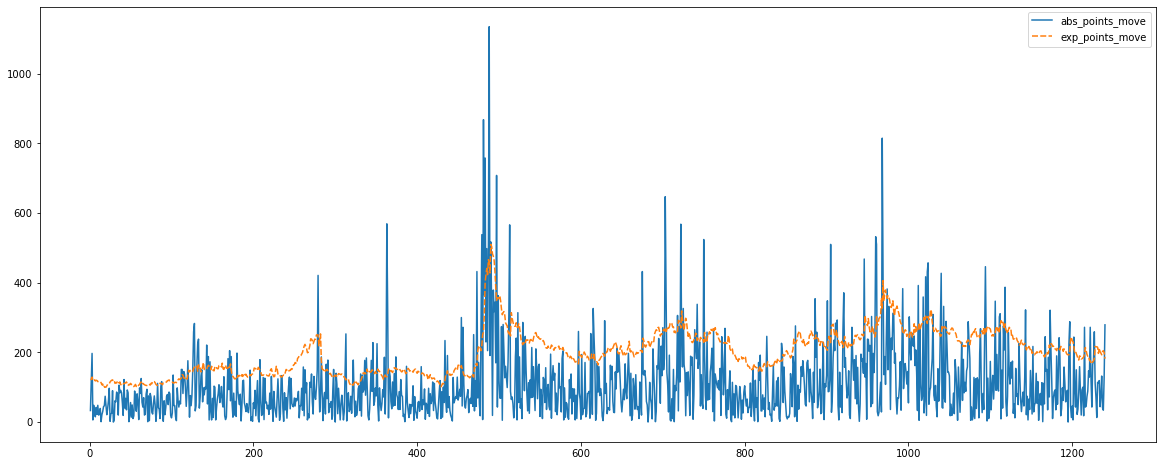

In [59]:
sns.lineplot(data=dff[["abs_points_move", "exp_points_move"]])

In [60]:
dff["overshoot"].value_counts()

False    1085
True      156
Name: overshoot, dtype: int64

In [61]:
overshoot_pct = dff["overshoot"].value_counts()[True] / dff.shape[0]
overshoot_pct.round(2)

0.13

# Add technical indicators  

### Function to add techincal indicators using pandas_ta library  

In [62]:
def add_technical_indicators(df: pd.DataFrame,
                                strategy: ta.Strategy):
    df_with_indicators = df.copy()
    df_with_indicators.ta.strategy(strategy)
    return df_with_indicators

In [63]:
# Define a custom strategy with technical indicators of interest  

custom_strategy = ta.Strategy(
    name = "SEAR",
    ta=[
    {"kind": "sma", "length": 20},
    {"kind": "ema", "length": 20},
    {"kind": "rsi", "length": 14},
    {"kind": "adx", "length": 14}
    ]
)

In [64]:
dfvt = add_technical_indicators(dff, custom_strategy)
dfvt

,datetime,open,high,low,close,volume,points_move,abs_points_move,returns,indiavix,...,lower,upper,overshoot,overshoot_points,SMA_20,EMA_20,RSI_14,ADX_14,DMP_14,DMN_14
0,2018-04-02 12:04:00,10151.65,10220.10,10127.75,10211.80,1.246128e+09,NaN,NaN,NaN,15.35,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-03 12:04:00,10186.85,10255.35,10171.05,10245.00,1.485609e+09,33.0,33.0,0.003251,15.19,...,10090.0,10334.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-04-04 12:04:00,10274.60,10279.85,10111.30,10128.40,1.822045e+09,-117.0,117.0,-0.011381,16.34,...,10123.0,10367.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-04-05 12:04:00,10228.45,10331.80,10227.45,10325.15,1.625293e+09,197.0,197.0,0.019426,14.80,...,9999.0,10257.0,True,68.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-04-06 12:04:00,10322.75,10350.45,10290.85,10331.60,1.629632e+09,6.0,6.0,0.000625,14.75,...,10206.0,10444.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,2023-03-24 12:03:00,17076.20,17109.45,16917.35,16945.05,2.021980e+09,-132.0,132.0,-0.007721,15.24,...,16884.0,17270.0,False,NaN,17276.1550,17263.324512,35.551229,29.444079,14.614978,33.611415
1237,2023-03-27 12:03:00,16984.30,17091.00,16918.55,16985.70,2.203406e+08,41.0,41.0,0.002399,15.45,...,16743.0,17147.0,False,NaN,17252.1500,17236.884082,37.373047,30.154511,13.718601,31.549934
1238,2023-03-28 12:03:00,17031.75,17061.75,16913.75,16951.70,2.164428e+08,-34.0,34.0,-0.002002,15.10,...,16781.0,17191.0,False,NaN,17230.1000,17209.723693,36.445081,30.831708,12.982666,30.031420
1239,2023-03-29 12:03:00,16977.30,17126.15,16940.60,17080.70,2.913668e+08,129.0,129.0,0.007610,13.63,...,16752.0,17152.0,False,NaN,17218.9375,17197.435723,42.299073,30.909819,14.449916,28.003173


In [65]:
dfvt.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'points_move',
       'abs_points_move', 'returns', 'indiavix', 'exp_move_pct',
       'exp_points_move', 'lower', 'upper', 'overshoot', 'overshoot_points',
       'SMA_20', 'EMA_20', 'RSI_14', 'ADX_14', 'DMP_14', 'DMN_14'],
      dtype='object')

# Visualize data  

In [66]:
overshoots = dfvt.loc[dfvt["overshoot"] == True]
overshoots["close"].size

156

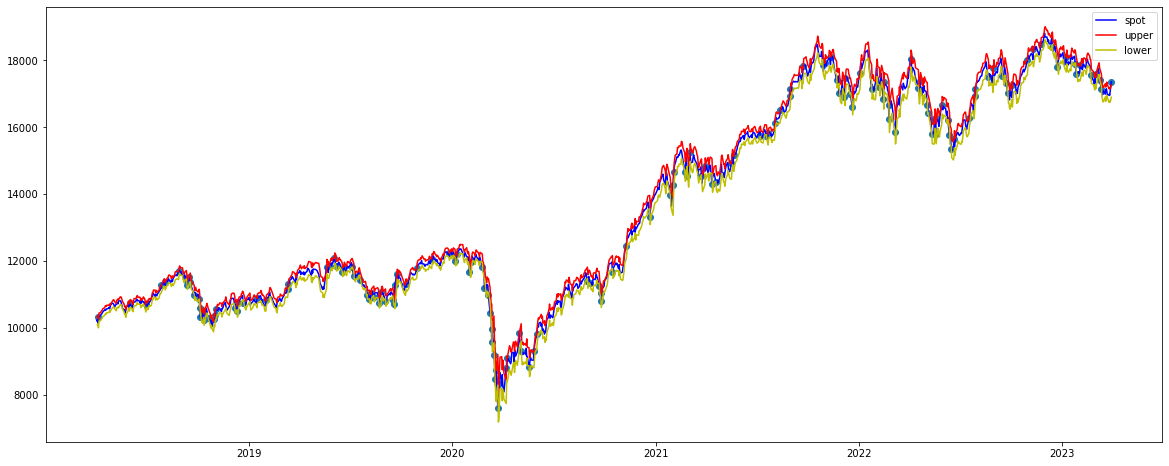

In [67]:
timeline = dfvt["datetime"]

spot_close = dfvt["close"]
upper_pred = dfvt["upper"]
lower_pred = dfvt["lower"]

plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(timeline, spot_close, color='b', label='spot')

plt.plot(timeline, upper_pred, color='r', label='upper')
plt.plot(timeline, lower_pred, color='y', label='lower')

overshoots = dfvt.loc[dfvt["overshoot"] == True]["close"]
tl = dfvt.loc[dfvt["overshoot"] == True]["datetime"]
plt.scatter(tl, overshoots)

plt.legend()
plt.show()

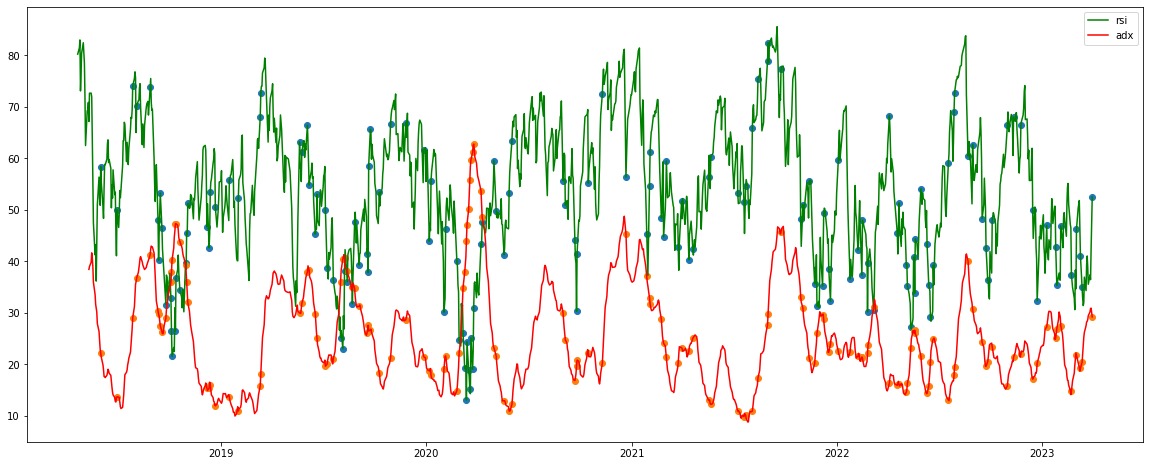

In [68]:
timeline = dfvt["datetime"]

rsi = dfvt["RSI_14"]
adx = dfvt["ADX_14"]

plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(timeline, rsi, color='g', label='rsi')
plt.plot(timeline, adx, color='r', label='adx')

overshoots_rsi= dfvt.loc[dfvt["overshoot"] == True]["RSI_14"]
overshoots_adx = dfvt.loc[dfvt["overshoot"] == True]["ADX_14"]
tl = dfvt.loc[dfvt["overshoot"] == True]["datetime"]
plt.scatter(tl, overshoots_rsi)
plt.scatter(tl, overshoots_adx)

plt.legend()
plt.show()

# Expiry day analysis  

### Function to look at data day-wise  

In [69]:
def day_wise_analysis(df: pd.DataFrame, day: str) -> pd.DataFrame:
    dfd = df.copy()
    dfd["day"] = dfd["datetime"].dt.day_name()
    dfd = dfd.loc[dfd["day"] == day]
    return dfd

In [70]:
dfvt_thu = day_wise_analysis(dfvt, "Thursday")
dfvt_thu.shape

(248, 23)

<AxesSubplot:>

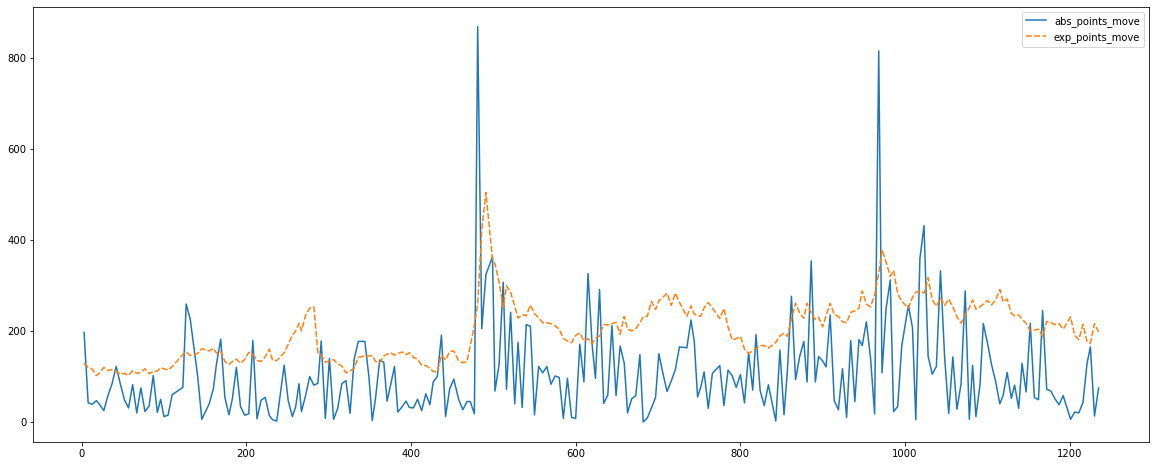

In [71]:
sns.lineplot(data=dfvt_thu[["abs_points_move", "exp_points_move"]])

In [72]:
dfvt_thu_overshoot = dfvt_thu.loc[dfvt_thu["overshoot"] == True]
dfvt_thu_overshoot.shape

(30, 23)

In [73]:
dfvt_thu_overshoot.tail()

,datetime,open,high,low,close,volume,points_move,abs_points_move,returns,indiavix,...,upper,overshoot,overshoot_points,SMA_20,EMA_20,RSI_14,ADX_14,DMP_14,DMN_14,day
1023,2022-05-19 12:05:00,15917.40,15984.75,15775.20,15809.4,2.125623e+09,-431.0,431.0,-0.026533,24.56,...,16523.0,True,148.0,16569.8175,16453.036095,33.755201,26.621050,18.205940,37.152529,Thursday
1043,2022-06-16 12:06:00,15832.25,15863.15,15335.10,15360.6,2.031871e+09,-332.0,332.0,-0.021128,22.87,...,15964.0,True,60.0,16235.8350,16156.877376,29.254481,20.533818,13.872771,37.969556,Thursday
1073,2022-07-28 12:07:00,16774.85,16947.65,16746.25,16929.6,2.285168e+08,288.0,288.0,0.017294,17.01,...,16878.0,True,52.0,16256.0600,16346.011937,69.103229,17.866153,36.250334,18.622002,Thursday
1152,2022-11-24 12:11:00,18326.10,18529.70,18294.25,18484.1,2.851593e+08,217.0,217.0,0.011871,13.48,...,18467.0,True,17.0,18181.0500,18140.563594,66.475121,21.999093,33.267624,18.050020,Thursday
1167,2022-12-15 12:12:00,18614.40,18652.90,18387.70,18414.9,5.031329e+08,-245.0,245.0,-0.013151,13.73,...,18848.0,True,57.0,18530.7125,18490.447388,49.979069,17.100174,23.584054,30.439463,Thursday


In [74]:
dfvt_thu_overshoot.tail()["datetime"].dt.date

1023    2022-05-19
1043    2022-06-16
1073    2022-07-28
1152    2022-11-24
1167    2022-12-15
Name: datetime, dtype: object

In [75]:
dfvt_thu_overshoot[['close', 'indiavix', 'overshoot_points']].describe().T

,count,mean,std,min,25%,50%,75%,max
close,30.0,13180.148333,3152.877242,9111.90,10712.6375,11756.050,15820.3875,18484.10
indiavix,30.0,20.256000,8.703952,11.89,14.6200,17.485,22.6675,49.75
overshoot_points,30.0,83.466667,133.623953,1.00,21.7500,47.000,77.0000,610.00


In [76]:
# dfvt_thu_overshoot.to_excel("dfvt_thu_overshoot_fy_18_23.xlsx")

In [77]:
# dfvt.to_excel("dfvt_fy_18_23.xlsx")

# Day wise rough for monday  

In [78]:
dfvt_mon = day_wise_analysis(dfvt, "Monday")
dfvt_mon.shape

(249, 23)

<AxesSubplot:>

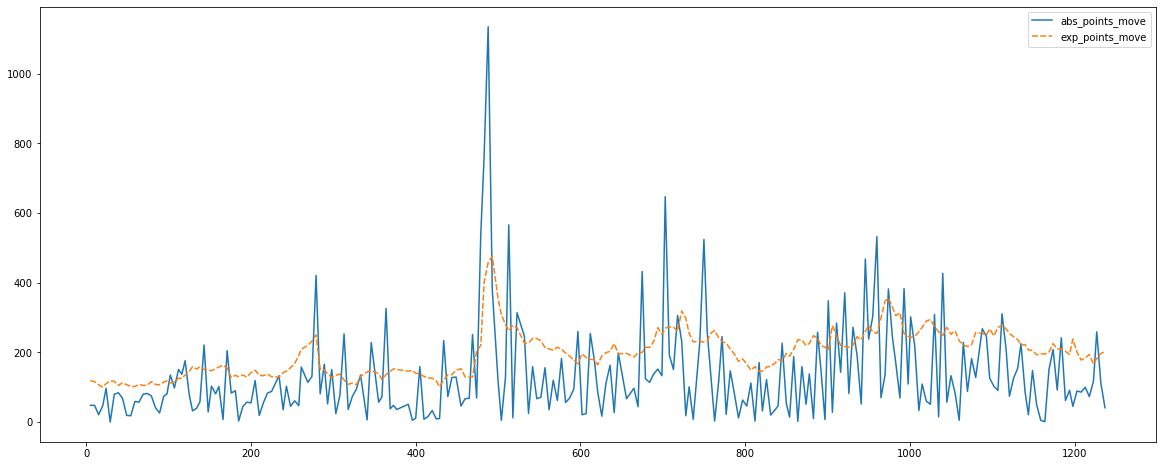

In [79]:
sns.lineplot(data=dfvt_mon[["abs_points_move", "exp_points_move"]])

In [80]:
dfvt_mon["overshoot_points"].describe()

count     53.000000
mean     105.245283
std      128.609861
min        2.000000
25%       23.000000
50%       50.000000
75%      142.000000
max      677.000000
Name: overshoot_points, dtype: float64